# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Natural Languague Processing 📝</p>

<p style="text-align:center">
    <a href="https://github.com/ITHealer?tab=repositories" target="_blank">
    <img src="avatar_healer.jpg" width="200" alt="Skills Network Logo"  />
    </a>
    <b>4251050044 - Ung Minh Hoài</b> <br>
</p>

# Sentiment analysis & Opinion mining

* Sử dụng Google Colab

In [24]:
# !pip install -qq transformers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# cd /content/drive/MyDrive/Colab Notebooks

In [25]:
pwd

'/content/drive/My Drive/Colab Notebooks'

# Google Play App Sentiment Analysis 

### Importing Required Libraries

In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)
sns.set_palette(sns.color_palette("rocket"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Let's start by defining some key variables that will be used later on in the training/evaluation process
# Hãy bắt đầu bằng cách xác định một số biến chính sẽ được sử dụng sau này trong quá trình đào tạo / đánh giá
RANDOM_SEED = 50
BATCH_SIZE = 16 # Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.
# Lưu ý rằng việc tăng kích thước lô làm giảm đáng kể thời gian đào tạo, nhưng mang lại cho bạn độ chính xác thấp hơn.
# Set seed for reproducibility.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
* [4. Model Building](#4)
* [5. Model Training](#5)
* [6. Load Pretrained Model](#6)
* [7. Model Evaluation 📊](#7)

<a id='1'></a>
# 1. Loading Dataset

In [46]:
df_reviews = pd.read_csv('data_tv.csv')
df_reviews.head()

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


In [47]:
print(f'Số dòng dữ liệu {df_reviews.shape[0]} dòng.')
print(f'Số cột của dữ liệu {df_reviews.shape[1]} cột.')

Số dòng dữ liệu 31460 dòng.
Số cột của dữ liệu 4 cột.


<a id='2'></a>
# 2. EDA

## 2.1. Kiểm tra giá trị bị thiếu hoặc rỗng

In [48]:
df_reviews.isnull().sum()

comment           0
label             0
rate              0
Unnamed: 3    31437
dtype: int64

## 2.2. Exploring the Target Column

In [31]:
# helper function to draw percentage above each bar
def draw_percentage(ax,total=float(len(df_reviews))):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center',va='bottom')

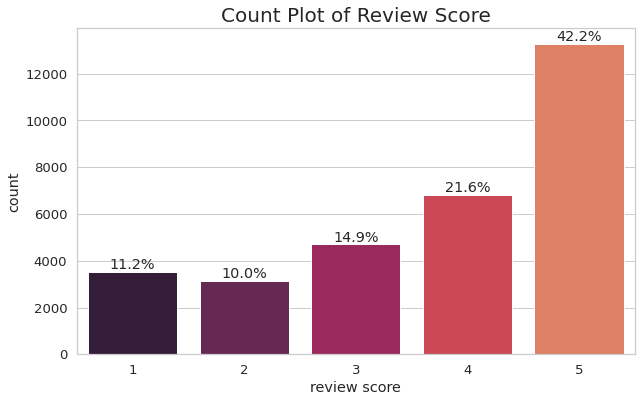

In [32]:
plt.figure(figsize = (10,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'rate',data=df_reviews)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review score')
draw_percentage(ax)
plt.show()

**Nó vô cùng mất cân bằng, nhưng không sao. Chúng ta sẽ chuyển đổi tập dữ liệu thành negative, neutral and positive sentiment.**

## 2.3 Covert score to sentiment

In [33]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
    
df_reviews['sentiment'] = df_reviews.rate.apply(to_sentiment)

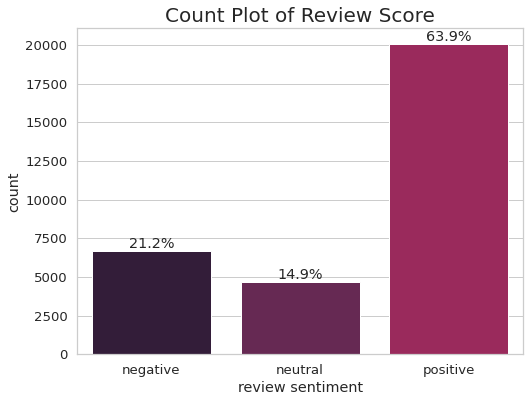

In [34]:
plt.figure(figsize = (8,6))
total = float(len(df_reviews))
ax = sns.countplot(x = 'sentiment',data=df_reviews)


class_names = ['negative', 'neutral', 'positive']
ax.set_xticklabels(class_names)
plt.title('Count Plot of Review Score', fontsize=20)
plt.xlabel('review sentiment')
draw_percentage(ax)

plt.show()

<a id='3'><a/>
# 3. Data Preprocessing

## 3.1. Tải mô hình

In [35]:
# We can use a cased and uncased version of BERT and tokenizer. I am using cased version.
# Chúng tôi có thể sử dụng phiên bản phân biệt và không phân biệt của BERT và tokenizer. Tôi đang sử dụng phiên bản cased.
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Let's load a pre-trained BertTokenizer/ Hãy tải một BertTokenizer được đào tạo trước
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
sample_txt = "we love you"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: we love you
   Tokens: ['we', 'love', 'you']
Token IDs: [1195, 1567, 1128]


In [37]:
# encoding of a sentence
encoding = tokenizer.encode_plus(
    sample_txt,
    padding='max_length', # Pad sentence to max length
    truncation=True,  #Truncate sentence to max length
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    return_attention_mask=True, # Return attention mask
    return_tensors='pt',  # Return torch objects
    )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a tensorflow tensor and padded to a length of 32.

In [38]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

32
tensor([ 101, 1195, 1567, 1128,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [39]:
# The attention mask has the same length
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

32
tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [40]:
# We can inverse the tokenization to have a look at the special tokens
# Chúng tôi có thể đảo ngược mã hóa để xem xét các mã thông báo đặc biệt
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'we',
 'love',
 'you',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## 3.2. Choosing Sequence Length

In [41]:
# BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length.
# Let's store the token length of each review..

token_lens = []
for text in df_reviews.comment:
    tokens = tokenizer.encode(text, truncation=True,max_length=512)
    token_lens.append(len(tokens))

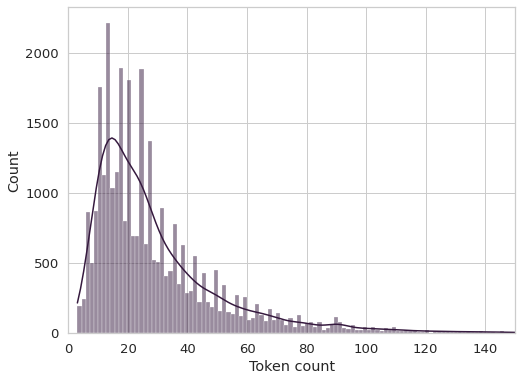

In [42]:
plt.figure(figsize = (8,6))
sns.histplot(token_lens,kde=True)
plt.xlim([0, 150])
plt.xlabel('Token count')
plt.show()

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 150.

In [43]:
MAX_LEN = 150

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model.

In [44]:
# We have all building blocks required to create a torch dataset. Let's do it...
class dataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        # step 1: get the reviews and targets
        review = str(self.reviews[item])
        target = self.targets[item]
        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            padding='max_length',  # Pad sentence to max length
            truncation=True,    # Truncate sentence to max length
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True, # Return attention mask
            return_tensors='pt', # return torch objects/tensor
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),  # Tensor of token ids to be fed to a model
            'attention_mask': encoding['attention_mask'].flatten(),  #Tensor of indices specifying which tokens should be attended to by the model
            'targets': torch.tensor(target, dtype=torch.long)
            }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

In [45]:
# lets split the data
df_train, df_test = train_test_split(df_reviews, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print('Train Data Size', df_train.shape)
print('Validation Data Size', df_val.shape)
print('Test Data Size', df_test.shape)

Train Data Size (28314, 5)
Validation Data Size (1573, 5)
Test Data Size (1573, 5)


We also need to create a couple of data loaders. Here's a helper function to do it.

In [46]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = dataset(
        reviews=df.comment.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size
      )


Apply dataloader on train, validation and test data.

In [47]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader

In [48]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

<a id='4'><a/>
# 4. Model Building

* Chúng tôi sẽ sử dụng BertModel cơ bản và xây dựng bộ phân loại tình cảm của chúng tôi trên đó. Hãy tải mô hình ..

In [49]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Note that warning occured because only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset.

Let's try to use it on the encoding of our sample text.

In [50]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state.
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence) and 768 is the number of hidden units in the feedforward-networks.We'll use all of this knowledge to create a classifier that uses the BERT model.

In [51]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        # dropout layer for some regularization 
        self.drop = nn.Dropout(p=0.3)
        # A fully-connected layer for our output
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        last_hidden_state,pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [52]:
# Let's create an instance and move it to the GPU.
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
# We'll move the example batch of our training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


<a id='5'></a>
# 5. Model Training

In [54]:
EPOCHS = 10
#  AdamW optimizer to correct weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
#  We'll also use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# cross-entropy loss function
loss_fn = nn.CrossEntropyLoss().to(device)

Let's continue with writing a helper function for training our model...

In [55]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    # put model in training mode
    model = model.train()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    for batch in data_loader:
        # We'll move the example batch of our training data to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        # Perform a forward pass. This will return logits.
        outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
        # Get the predictions
        _, preds = torch.max(outputs, dim=1)

        # Compute loss and accumulate the loss values
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # Calculate the accuracy rate
        correct_predictions += torch.sum(preds == targets)
        # backward pass - Perform a backward pass to calculate gradients
        loss.backward()
        # gradient clipping - Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()
        # Zero out any previously calculated gradients
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)  # Compute the average accuracy and loss over the training set.

Let's write another one that helps us evaluate the model on a given data loader.

In [56]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # put model in evaluation mode
    model = model.eval()
    # Create empty lists to store outputs
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            # We'll move the example batch of our validation data to the GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device) 

            # Perform a forward pass. This will return logits.
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            # Get the predictions
            _, preds = torch.max(outputs, dim=1) 

            # Compute loss and accumulate the loss values
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            # Calculate the accuracy rate
            correct_predictions += torch.sum(preds == targets)
            
    return correct_predictions.double() / n_examples, np.mean(losses) # Compute the average accuracy and loss over the validation set.

Using those two helper function, we can write our training loop. We'll also store the training history for future use...

In [57]:
%%time
history = defaultdict(list)
best_accuracy = 0
# Start training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 100)
    # model training
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    # After the completion of each training epoch, measure the model's performance on our validation set.
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss   {val_loss} accuracy {val_acc}')
    print()
    # append training accuracy,loss and validation accuracy and loss to the history variable
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model based on below condition
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------------------------------------------------------------------------------------------------
Train loss 0.6307903301917901 accuracy 0.7426361517270608
Val loss   0.5767550376629589 accuracy 0.7539732994278449

Epoch 2/10
----------------------------------------------------------------------------------------------------
Train loss 0.5208333114698782 accuracy 0.7915165642438369
Val loss   0.5701251136835175 accuracy 0.7635092180546726

Epoch 3/10
----------------------------------------------------------------------------------------------------
Train loss 0.46898138820704094 accuracy 0.813837677474041
Val loss   0.6163195874353852 accuracy 0.7635092180546726

Epoch 4/10
----------------------------------------------------------------------------------------------------
Train loss 0.41998762496152503 accuracy 0.8385957476866567
Val loss   0.6773869502122956 accuracy 0.7469802924348379

Epoch 5/10
------------------------------------------------------------------------

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy.

In [58]:
history_cpu_train_acc = [i.cpu() for i in history['train_acc']]
history_cpu_val_acc = [i.cpu() for i in history['val_acc']]

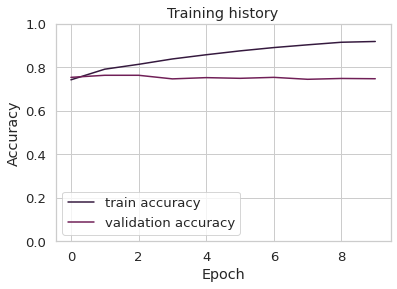

In [59]:
plt.plot(history_cpu_train_acc, label='train accuracy')
plt.plot(history_cpu_val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

The training accuracy starts to approach 90% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

<a id='6'><a/>
# 6. Load Pretrained Model

In [60]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<a id='7'><a/>
# 7. Model Evaluation

In [61]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7832167832167832

The accuracy is very low on the test set. Our model needs tuning.

lets check the prediction, we'll define a helper function to get the predictions from our model.

In [62]:
def get_predictions(model, data_loader):
    # put model in evaluation mode
    model = model.eval()
    # Create empty lists to store outputs
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
    for batch in data_loader:
      # We'll move the example batch of our test data to the GPU
      texts = batch["review_text"]
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["targets"].to(device)
      # Perform a forward pass. This will return logits.
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # Get the predictions
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities.

In [63]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report.

In [64]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.71      0.72      0.71       316
     neutral       0.41      0.30      0.34       215
    positive       0.86      0.90      0.88      1042

    accuracy                           0.78      1573
   macro avg       0.66      0.64      0.65      1573
weighted avg       0.77      0.78      0.77      1573



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix-

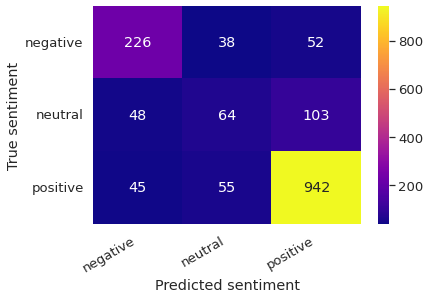

In [65]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="plasma")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews.

That's a good overview of the performance of our model. But let's have a look at an example from our test data.

In [66]:
idx = 50
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

from textwrap import wrap 
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Góp ý với shop đóng hộp carton thì tốt hơn.

True sentiment: neutral


Now, we can look at the confidence of each sentiment of our mode.

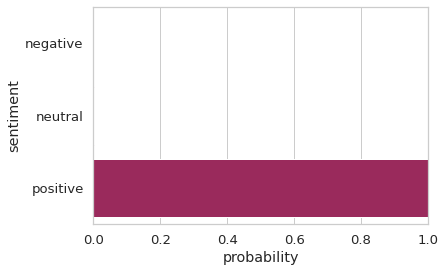

In [67]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])
plt.show()

### Prediction on Raw Text

In [73]:
def prediction_on_raw_data(raw_text):
  encoded_review = tokenizer.encode_plus(
  raw_text,
  padding='max_length', # Pad sentence to max length
  truncation=True,  #Truncate sentence to max length
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True, # Return attention mask
  return_tensors='pt',  # Return torch objects
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)

  _, prediction = torch.max(output, dim=1)
  
  print(f'Review text: {raw_text}')
  print(f'Sentiment  : {class_names[prediction]}')



In [76]:
# Let's use our model to predict the sentiment of some raw text
raw_text = "Nó khá là khó hiểu và làm tôi bị rối."


In [77]:
prediction_on_raw_data(raw_text)

Review text: Nó khá là khó hiểu và làm tôi bị rối.
Sentiment  : negative


In [75]:
raw_text = "Nó thật dễ sử dụng và tiện lợi. Good job"
prediction_on_raw_data(raw_text)


Review text: Nó thật dễ sử dụng và tiện lợi. Good job
Sentiment  : positive


In [80]:
raw_text = "Tôi thấy nó khá ổn"
prediction_on_raw_data(raw_text)

Review text: Tôi thấy nó khá ổn
Sentiment  : neutral


# END